In [4]:
# importing libraries
import pandas as pd
import pandas.util.testing as tm
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline
import datetime
from datetime import datetime
import statistics as st
import scipy
from pylab import rcParams
import seaborn as sb
from scipy.stats.stats import pearsonr
rcParams['figure.figsize'] = 10,9
sb.set_style('whitegrid')
from scipy.stats import ttest_ind
pd.set_option('mode.chained_assignment', None)


# Analysis of Cycling Data

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `scripts/stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [5]:
strava = pd.read_csv('data/Portfolio1/strava_export.csv',index_col='date',parse_dates = True)
strava.sort_index()


,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-02 20:47:51+00:00,100.6,21.0,73.8,False,15.2,94,316.00 m,10,73,Ride
2018-01-04 01:36:53+00:00,NaN,24.0,131.7,False,18.0,52,236.00 m,5,46,Ride
2018-01-04 02:56:00+00:00,83.1,25.0,13.8,False,0.0,3,0.00 m,2,2,Ride
2018-01-04 05:37:04+00:00,110.1,24.0,113.6,False,22.9,77,246.00 m,8,64,Ride
2018-01-05 19:22:46+00:00,110.9,20.0,147.7,True,58.4,189,676.00 m,12,144,Ride
...,...,...,...,...,...,...,...,...,...,...
2019-07-19 20:22:49+00:00,NaN,3.0,166.8,True,58.2,174,666.00 m,16,136,Ride
2019-07-26 20:12:56+00:00,120.8,7.0,166.9,True,59.6,185,663.00 m,15,139,Ride
2019-07-27 20:42:59+00:00,122.0,3.0,168.4,True,19.8,49,247.00 m,6,47,Ride


The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [8]:
cheetah = pd.read_csv('data/Portfolio1/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')

The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in thier documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  


__The first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in both data frames so that we have complete data for every row.__

* Since the strava timezone is in different format, I am parsing the date field of strava to Australian local time using lambda function.

In [9]:
strava = pd.read_csv('data/Portfolio1/strava_export.csv',parse_dates=[3],date_parser=lambda x: pd.Timestamp(x,  tz= 'Australia/Sydney'))

* I need to use an inner join operation to retain matched data between Cheetah and Strava data set.

In [21]:
Merge_Strava_Cheetah = strava.join(cheetah, how= 'inner',on='date' , rsuffix= True )

* I am retaining one copy of data set so that I can validate the data if there is any filter applied.

In [20]:
merge_Strava_Cheetah_copy = strava.join(cheetah, how= 'inner',on='date' , rsuffix= True )

__Question 1. Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides__

* Storing the result of both device_watts as false and workout_type as 'Ride' in a field.

In [22]:
Device_Watts_False = Merge_Strava_Cheetah[Merge_Strava_Cheetah.device_watts == 0]
Device_Watts_False_With_Ride = Device_Watts_False[Device_Watts_False.workout_type == 'Ride']

* Storing the result in an index and applying drop logic.

In [23]:
idx = Device_Watts_False[Device_Watts_False.workout_type == 'Ride'].index 
Merge_Strava_Cheetah.drop(idx,inplace = True)

* Applying assert function to validate whether the drop operation worked or not.

In [24]:
assert len(merge_Strava_Cheetah_copy) - len(Merge_Strava_Cheetah) == len(Device_Watts_False_With_Ride), "Drop didn't work"

__2. Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed?__

* Plotting a histogram to check whether moving_time variable is normally distributed or not. 

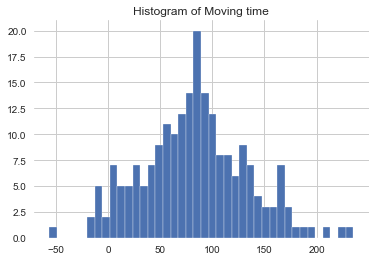

82.67924528301887


In [25]:
mean = Merge_Strava_Cheetah['moving_time'].mean()
std = Merge_Strava_Cheetah['moving_time'].std()
count = Merge_Strava_Cheetah['moving_time'].size
plt.title('Histogram of Moving time')
counts = np.random.normal(mean,std,count)
plt.hist(counts,bins =40)
plt.show()
print(mean)

__Interpretation:-__ Plotting the histogram based on mean, standard deviation and count of moving_time field. The mean is 82.67. The graph looks normally distributed with gaps between -50 to 0 and beyond 200.

34.676841981132085


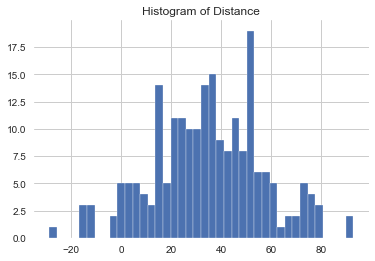

In [32]:
mean = Merge_Strava_Cheetah['Distance'].mean()
std = Merge_Strava_Cheetah['Distance'].std()
count = Merge_Strava_Cheetah['Distance'].size
print(mean)
plt.title('Histogram of Distance')
counts = np.random.normal(mean,std,count)
plt.hist(counts,bins =40)
plt.show()

__Interpretation:-__ Plotting the histogram based on mean, standard deviation and count of moving_time field. The mean is 34.67. Since the tail is inclined on the left side, the graph is left skewed.

25.12897849056604


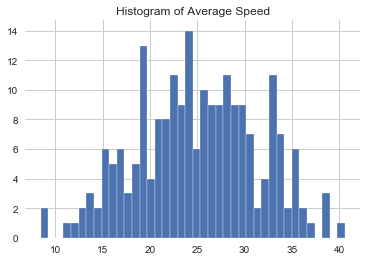

In [38]:
mean = Merge_Strava_Cheetah['Average Speed'].mean()
std = Merge_Strava_Cheetah['Average Speed'].std()
count = Merge_Strava_Cheetah['Average Speed'].size
print(mean)
plt.title('Histogram of Average Speed')
counts = np.random.normal(mean,std,count)
plt.hist(counts,bins =40)
plt.show()

__Interpretation:-__ Plotting the histogram based on mean, standard deviation and count of moving_time field. The mean is 25.12. The graph approximately looks like a symmetric distribution. Therefore, we can say that the graph is normally distributed.

160.08522169811323


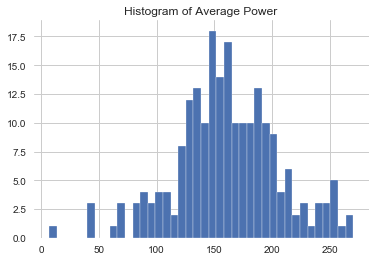

In [14]:
mean = Merge_Strava_Cheetah['Average Power'].mean()
std = Merge_Strava_Cheetah['Average Power'].std()
count = Merge_Strava_Cheetah['Average Power'].size
print(mean)
plt.title('Histogram of Average Power')
counts = np.random.normal(mean,std,count)
plt.hist(counts,bins =40)
plt.show()

__Interpretation:-__ Plotting the histogram based on mean, standard deviation and count of moving_time field. The mean is 160.08. Since the tail is inclined on the left side, the graph is left skewed.

97.21823254716979


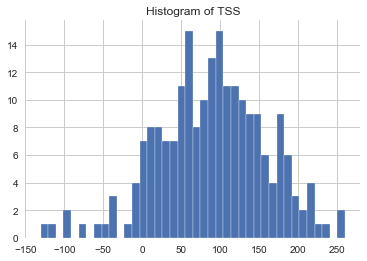

In [15]:
mean = Merge_Strava_Cheetah['TSS'].mean()
std = Merge_Strava_Cheetah['TSS'].std()
count = Merge_Strava_Cheetah['TSS'].size
print(mean)
plt.title('Histogram of TSS')
counts = np.random.normal(mean,std,count)
plt.hist(counts,bins =40)
plt.show()

__Interpretation:-__ Plotting the histogram based on mean, standard deviation and count of moving_time field. The mean is 97.21. Since the tail is inclined on the left side, the graph is left skewed.

__3. Explore the relationships between the following variables. Are any of them corrolated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?__
    * Distance
    * Moving Time
    * Average Speed
    * Heart Rate
    * Power (watts)
    * Normalised power (NP)
    * Training Stress Score
    * Elevation Gain

* __Step1:-__ Creating a new datafame that contains specific fields from the large set of data columns.

In [40]:
rt = pd.DataFrame(Merge_Strava_Cheetah,columns = ['Distance','Time Moving','Average Speed','Average Heart Rate','Average Power','NP','TSS','Elevation Gain'])

* __Step2:-__ Checking correlationship between specific fields.

In [41]:
corr = rt.corr()
corr

,Distance,Time Moving,Average Speed,Average Heart Rate,Average Power,NP,TSS,Elevation Gain
Distance,1.000000,0.934185,0.234375,0.173256,0.164562,0.287567,0.917104,0.807242
Time Moving,0.934185,1.000000,-0.040434,0.037252,-0.045643,0.101212,0.866582,0.812870
Average Speed,0.234375,-0.040434,1.000000,0.386003,0.770931,0.650656,0.160946,0.027793
Average Heart Rate,0.173256,0.037252,0.386003,1.000000,0.387190,0.273245,0.174781,0.050323
Average Power,0.164562,-0.045643,0.770931,0.387190,1.000000,0.875896,0.272301,0.002386
NP,0.287567,0.101212,0.650656,0.273245,0.875896,1.000000,0.450335,0.236570
TSS,0.917104,0.866582,0.160946,0.174781,0.272301,0.450335,1.000000,0.826334
Elevation Gain,0.807242,0.812870,0.027793,0.050323,0.002386,0.236570,0.826334,1.000000


__Interpretation:-__ The degree of correlation ranges from -1 to 1. Here, -1 represent strong negative degree of correlation and 1 represent strong positive degree of correlation. The "Distance" vs "Time moving" represent strong positive degree of correlation with value 0.93. The 'Time Moving' vs 'Avg speed', 'Time Moving' vs 'Average heart rate','Time Moving' vs  'Avg Power','Time Moving' vs  'Np' represent the lowest degree of correlation as there value is extremely negatively low. From the relationship table, we can see that its quite hard to figureout the degree of correlationship based on the numerical values presented on the table. We need to draw a heatmap diagram that shows the visualization of correlationship between these fields.

Text(0.5, 1, 'Heatmap diagram that reveals relationship between variables')

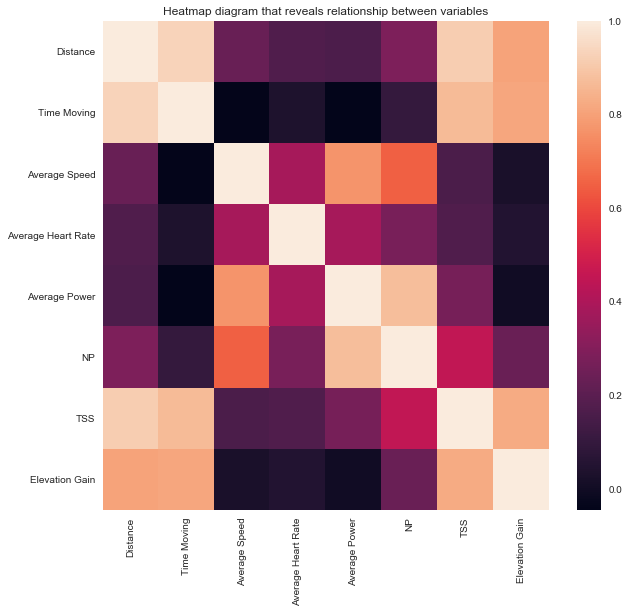

In [44]:
sb.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values)
plt.title('Heatmap diagram that reveals relationship between variables')

__Interpretation:-__ The light orange color shows the strongest correlation and the black color shows the weakest correlation. The light orange color that has the strongest correlations can be seen for 'Distance Vs Time Moving'. The black color that has the weakest correlation can be seen for 'Time Moving vs Average speed', 'Average speed vs Time Moving', and so on. The heatmap visualization techniques provide a convenient and clear picture of the relationship between fields.

__4. Some of the rides are designated as "Race" in the `workout_type` field, these are where I am racing and you might expect that these would be the most challenging rides.  Normalised Power (NP) is a good measure of how hard a ride is.  Explore the values of `NP` for races vs the overall set of rides to see if this hypothesis is supported (use graphs and summary statistics).  Are races more challenging than rides in general?__

* __Step1:-__ Storing the result of workout_type field as Race and checking the summary statistics.

In [45]:
Race = Merge_Strava_Cheetah[Merge_Strava_Cheetah['workout_type'] == 'Race']
Race_NP = Race[['NP','workout_type']]
Race_NP.describe()

,NP
count,30.000000
mean,251.003800
std,50.774197
min,0.000000
25%,244.716250
50%,257.170000
75%,272.654250
max,302.396000


__Interpretation:-__ From the summary statistics, we can see that the average value of NP for races is 251.003 and count is 30.

In [46]:
merge_totalrecords_NP=Merge_Strava_Cheetah[['NP','workout_type']]
merge_totalrecords_NP.describe()

,NP
count,212.000000
mean,215.759731
std,49.747963
min,0.000000
25%,203.262000
50%,222.906500
75%,239.860750
max,302.396000


__Interpretation:-__ From the summary statistics, we can see that the average value of NP for over all ride is 251.75 and the count is 212. Comparing overall rides vs values in NP,  only 14.15% of total participants are in race.

Text(0.5, 1.0, 'Values of NP Vs Overall set of data')

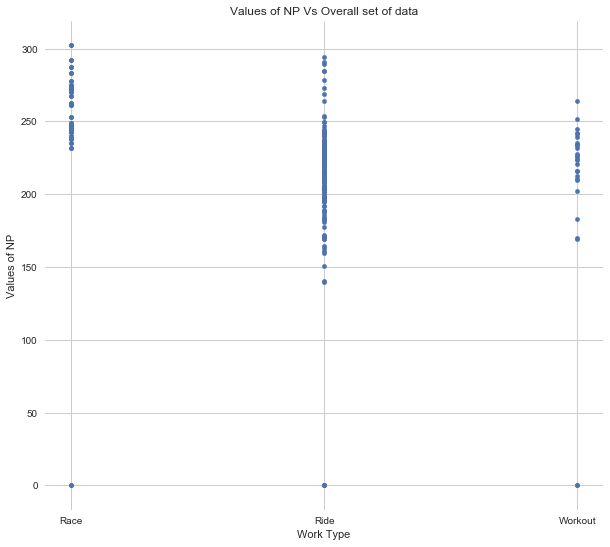

In [50]:
ax1 = Race_NP.plot(kind='scatter', x= 'workout_type', y='NP')    
ax2 = merge_totalrecords_NP.plot(kind='scatter',x= 'workout_type', y='NP', ax=ax1)  
plt.xlabel('Work Type')
plt.ylabel('Values of NP')
plt.title('Values of NP Vs Overall set of data')

__Interpretation:-__ Plotting scatter diagram between Values of NP vs Overall set of data, we can see that a larger number of participants preferred Ride comparing to Race and Workout. We can conclude that participants mostly enjoyed going to Ride. We also see a considerably low number of participants preferring Race work type. Also, the participants who preferred the Race work type seem to have considerably large values of NP. Since the larger values of NP is a good measure of how hard the ride is. We can say that Race is more challenging than Ride.

__5. It is useful to see a summary of rides over the year. Generate a plot that summarises the number of km ridden each month over the period of the data. Overlay this with the _sum_ of the Training Stress Score and the _average_ of the Average Speed to generate an overall summary of activity.__


* __Step1:-__ Storing the result of a ride in a variable and calculating total distance covered based on each month using groupby function.

In [69]:
Ride_take = Merge_Strava_Cheetah[Merge_Strava_Cheetah['workout_type']=='Ride']
Ride_take['date'] = pd.to_datetime(Ride_take['date'])
Ride_take['Month'] = Ride_take['date'].dt.month
MonthVsdistance = Ride_take.groupby("Month")['distance'].sum()
MonthVsdistanceFinal = MonthVsdistance.reset_index()
MonthVsdistanceFinal

,Month,distance
0,1,351.1
1,2,618.5
2,3,757.1
3,4,907.5
4,5,632.8
5,6,481.0
6,7,467.2
7,8,103.1
8,9,160.6
9,10,388.8


* __Step2:-__ Similarly, calculating total TSS based on each month using groupby function.

In [70]:
MonthVsTSS = Ride_take.groupby("Month")['TSS'].sum()
MonthVsTSSFinal = MonthVsTSS.reset_index()
MonthVsTSSFinal

,Month,TSS
0,1,966.2920
1,2,1683.9476
2,3,2494.5250
3,4,2517.4567
4,5,1733.9907
5,6,1432.3450
6,7,1219.7014
7,8,331.4360
8,9,564.7220
9,10,951.4079


* __Step3:-__ Similarly, calculating Average of Average speed based on each month using groupby function.

In [71]:
MonthVsAverageSpeed = Ride_take.groupby('Month')['Average Speed'].mean()
MonthVsAverageSpeedFinal = MonthVsAverageSpeed.reset_index()
MonthVsAverageSpeedFinal

,Month,Average Speed
0,1,20.172441
1,2,23.742950
2,3,23.752011
3,4,22.012100
4,5,25.163340
5,6,24.184394
6,7,23.706800
7,8,24.603700
8,9,24.427367
9,10,25.648018


* __Step4:-__  As we need to show the relation between month based on distance, TSS and Avg of Average speed. Plotting and interpreting the data in a single graph can be confusing. We need to use subplots to plot data in separate graphs.

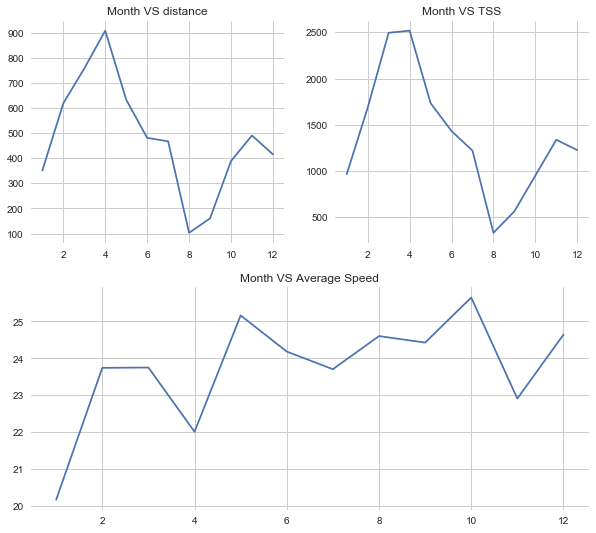

In [72]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

ax1.plot(MonthVsdistanceFinal['Month'],MonthVsdistanceFinal['distance']); ax1.set_title('Month VS distance');ax1.ylabel ='Distance';ax1.xlabel ='Month';
ax2.plot(MonthVsdistanceFinal['Month'],MonthVsTSSFinal['TSS']); ax2.set_title('Month VS TSS')
ax3.plot(MonthVsdistanceFinal['Month'],MonthVsAverageSpeedFinal['Average Speed']); ax3.set_title('Month VS Average Speed')
plt.show()

__Interpretation:-__ 
1. While comparing Month Vs distance, April is the month where most people traveled to maximum distance and from April to August, we see a drastic drop in total distance traveled and from September onwards, we again see an increase in total distance.
2. While comparing Month Vs TSS, March is the month where most people has training stress score and from April to June, we see a drastic drop in training stress score and from July onwards, we again see an increase in TSS trend.
3. While comparing Month Vs Average Speed, we see a fluctuation of average speed throughout the year. From January, we see a rise in average speed and in march we again see a drop in average speed. Likewise in April, we see a drastic increase in average speed. In conclusion, throughout the month we see fluctuation in the data.